<a href="https://colab.research.google.com/github/Hamza-Suleman/transiting-exoplanets/blob/main/Wrapper_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Creating a Wrapper Function

This notebook will follow the creation and testing of a wrapper function to analyse raw transit data using Python.

##Installing Dependencies

In [1]:
!pip install batman-package
!pip install astropy
!pip install transitleastsquares
from scipy.optimize import minimize
!python -c 'import batman;batman.test()'
import batman
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from transitleastsquares import transitleastsquares
from IPython.display import display, Math
!pip install -U setuptools setuptools_scm pep517
!pip install -U emcee
import emcee
import statistics

     |████████████████████████████████| 394 kB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for batman-package: filename=batman_package-2.4.8-cp37-cp37m-linux_x86_64.whl size=220949 sha256=f3da450171f29958a3dc01a206645ba8cb592f0303ebd04e12b8cff43cdc15cb
  Stored in directory: /root/.cache/pip/wheels/97/50/fb/df66c5937af30045fded1ee31db1d58510ef4e2681d5b4590c
Successfully built batman-package
     |████████████████████████████████| 47 kB 2.5 MB/s 
     |████████████████████████████████| 4.5 MB 8.9 MB/s 
     |████████████████████████████████| 840 kB 65.6 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 3.6 MB 50.3 MB/s 
  Created wheel for pyvo: filename=pyvo-1.2.1-py3-none-any.whl size=831658 sha256=a0b83d3e3803333ed671f780c50626bc45c5e3ed7c05031d392e014d3e0ab281
  Stored in directory: /root/.cache/pip/wheels/97/03/e6/5572c24d6c

     |████████████████████████████████| 45 kB 1.9 MB/s 


##Creating the Wrapper Function

This code will be the main body of the wrapper function, it will take various inputs and find the parameters of the transit and their errors.

In [22]:
def transit_analysis(data):

  manual_params = [3.719,4.78,0.085,10,90.5,0] #This is an empty list that will eventually populate with manaul input parameters.
  param_definitions = ["Time of Inferior Conjunction", "Orbital Period", "Planet Radius", "Semi-major Axis", "Orbital Inclination", "Y-Offset"]

  #Importing raw data
  raw_data = ascii.read(data)
  raw_time = []
  raw_flux = []
  raw_flux_err = []
  for i in range(len(raw_data)):
    raw_time.append(raw_data[i][0])
    raw_flux.append(raw_data[i][1])
    raw_flux_err.append(raw_data[i][2])
  raw_time = np.array(raw_time)
  raw_flux = np.array(raw_flux)
  raw_flux_err = np.array(raw_flux_err)
  #plt.plot(raw_time,raw_flux)

  #A function to plot a transit from BATMAN parameters, and a list of time and flux values.
  def transit_plot(par,t,xaxis="Time",plottype="line",colour="b",transparency=None):   #creating a function to take a list parameter inputs and plot a lightcurve
    params = batman.TransitParams()
    params.t0 = par[0]                      #time of inferior conjunction
    params.per = par[1]                     #orbital period
    params.rp = par[2]                      #planet radius (in units of stellar radii)
    params.a = par[3]                       #semi-major axis (in units of stellar radii)
    params.inc = par[4]                     #orbital inclination (in degrees)
    params.ecc = 0                          #eccentricity
    params.w = 90                           #longitude of periastron (in degrees)
    params.u = [0.1, 0.3]                   #limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"          #limb darkening model
    m = batman.TransitModel(params, t)      #initializes model
    flux = m.light_curve(params) + par[5]            #calculates light curve
    if plottype == "scatter":
      plt.scatter(t,flux,color=colour,alpha=transparency)
    else:
      plt.plot(t, flux,color=colour,alpha=transparency)
    plt.xlabel(xaxis)
    plt.ylabel("Relative flux")
    plt.show()

  #This function will allow the user to fit parameters manually to the data, inside the wrapper function.
  def manual_fitting(t,f,par):
    user_input = "no"
    while user_input.lower() == "no":
      print("\nTrying Parameters:")
      print(manual_params)
      #plt.figure(figsize=(30,10))
      plt.scatter(t,f)
      transit_plot(manual_params,t,colour="r",transparency=0.7)
      #plt.show()
      user_input = input("\nDo these parameters fit?\n")
      if user_input.lower() == "no":
        for i in range(len(manual_params)):
          manual_params[i] = float(input("Enter a value for " + param_definitions[i] + " Parameter: "))
    print("\nFinal Manual Parameters:")
    print(manual_params)

  #MCMC Analysis (on parameters: inferior conjunction, planet radius, semi-major axis, inclination)
  def log_likelihood(par, t, flux, flux_error):
    params = batman.TransitParams()
    params.t0 = par[0]                      #time of inferior conjunction
    params.per = 4.78070560                 #orbital period
    params.rp = par[1]                      #planet radius (in units of stellar radii)
    params.a = par[2]                       #semi-major axis (in units of stellar radii)
    params.inc = par[3]                     #orbital inclination (in degrees)
    params.ecc = 0                          #eccentricity
    params.w = 90                           #longitude of periastron (in degrees)
    params.u = [0.1, 0.3]                   #limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic" 
    LC_model = batman.TransitModel(params, t)
    LC_flux = LC_model.light_curve(params) + par[4]  #calulating lightcurve flux values from input parameters
    return -0.5 * np.nansum(((LC_flux - flux)**2)/flux_error**2) #return log likelihood
  
  def log_prior(par):
    #print(par)
    if par[0] > 0 and 0 < par[1] < 1 and par[2] > 0 and 0 < par[3] < 90: #these are limits we know to be true for the parameters that we have
        return 0.0
    #print("inf")
    return -np.inf

  def log_probability(par, t, flux, flux_error):
    lp = log_prior(par)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(par, t, flux, flux_error)

  def MCMC(par, t, flux, flux_error):
    pos = par + 1e-4 * np.random.randn(50, 5)
    nwalkers, ndim = pos.shape
    sampler = emcee.EnsembleSampler(
      nwalkers, ndim, log_probability, args=(t, flux, flux_error)
    )
    sampler.run_mcmc(pos, 5000, progress=True); 
    samples = sampler.get_chain()
    fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
    labels = ["t0", "rp", "a","inc","y-offset"]
    for i in range(ndim):
      ax = axes[i]
      ax.plot(samples[:, :, i], "k", alpha=0.3)
      ax.set_xlim(0, len(samples))
      ax.set_ylabel(labels[i])
      ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");
    params = np.zeros((5,3))
    flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
    print("These are the variables calculated by MCMC analysis:")
    for i in range(ndim):
      mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
      q = np.diff(mcmc)
      txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
      txt = txt.format(mcmc[1], q[0], q[1], labels[i])
      display(Math(txt))
      params[i] = (mcmc[1], q[0], q[1])
    return flat_samples,params

  #running the function

  manual_fitting(raw_time,raw_flux,manual_params)

  #cleaning the manual parameters to be used in MCMC analysis
  if manual_params[4] > 90:
    manual_params[4] = 90-(manual_params[4]-90)

  print("\nRunning MCMC Analysis:\n")
  mcmc_input_params = [manual_params[0],manual_params[2],manual_params[3],manual_params[4],manual_params[5]]
  mcmc_input_params = np.array(mcmc_input_params)
  mcmc_output = MCMC(mcmc_input_params,raw_time,raw_flux,raw_flux_err)
  flat_samples = mcmc_output[0]
  mcmc_params = mcmc_output[1]
  print("Output Parameters from MCMC Analysis")
  #print(mcmc_params)
  
  return mcmc_params

###Testing on Initial Dataset


Trying Parameters:
[3.719, 4.78, 0.085, 10, 90.5, 0]


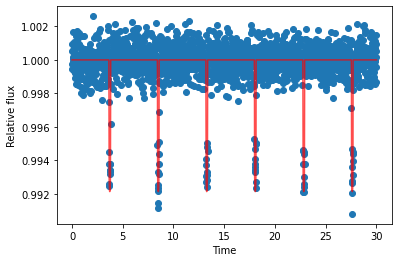


Do these parameters fit?
yes

Final Manual Parameters:
[3.719, 4.78, 0.085, 10, 90.5, 0]

Running MCMC Analysis:



100%|██████████| 5000/5000 [00:59<00:00, 83.59it/s]


These are the variables calculated by MCMC analysis:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Output Parameters from MCMC Analysis


array([[3.71765573e+00, 6.24400804e-04, 6.62964588e-04],
       [7.97432768e-02, 8.20763679e-04, 9.75871977e-04],
       [8.28031257e+00, 8.13791007e-01, 6.59651864e-01],
       [8.71422430e+01, 1.49528469e+00, 1.70810641e+00],
       [3.83627244e-06, 1.77265762e-05, 1.73024792e-05]])

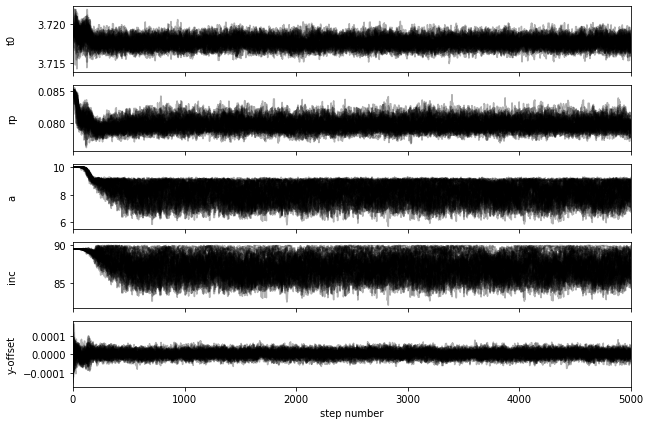

In [23]:
transit_analysis("https://raw.githubusercontent.com/Hamza-Suleman/transiting-exoplanets/main/Transit_model_LC_data.txt")

###Testing on Follow-Up Dataset


Trying Parameters:
[3.719, 4.78, 0.085, 10, 90.5, 0]


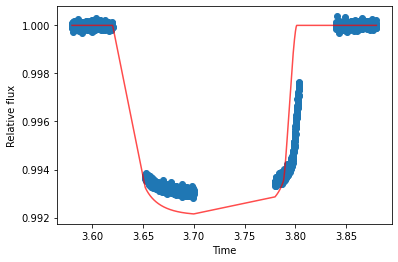


Do these parameters fit?
no
Enter a value for Time of Inferior Conjunction Parameter: 3.72e+00
Enter a value for Orbital Period Parameter: 4.78070560e+00
Enter a value for Planet Radius Parameter: 8.1e-02
Enter a value for Semi-major Axis Parameter: 8.16e+00
Enter a value for Orbital Inclination Parameter: 9.31147956e+01
Enter a value for Y-Offset Parameter: -0.002

Trying Parameters:
[3.72, 4.7807056, 0.081, 8.16, 93.1147956, -0.002]


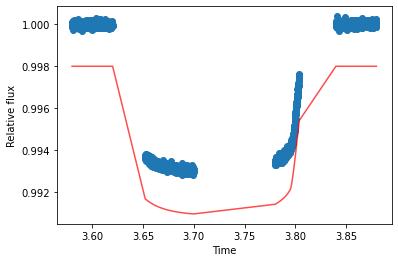


Do these parameters fit?
no
Enter a value for Time of Inferior Conjunction Parameter: 3.72
Enter a value for Orbital Period Parameter: 4.78
Enter a value for Planet Radius Parameter: 8.1e-2
Enter a value for Semi-major Axis Parameter: 8.16
Enter a value for Orbital Inclination Parameter: 9.311e1
Enter a value for Y-Offset Parameter: 0.0001

Trying Parameters:
[3.72, 4.78, 0.081, 8.16, 93.11, 0.0001]


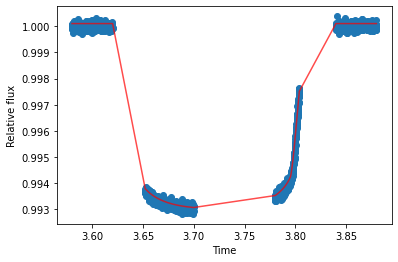


Do these parameters fit?
yes

Final Manual Parameters:
[3.72, 4.78, 0.081, 8.16, 93.11, 0.0001]

Running MCMC Analysis:



100%|██████████| 5000/5000 [01:33<00:00, 53.20it/s]


These are the variables calculated by MCMC analysis:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Output Parameters from MCMC Analysis


array([[3.71978005e+00, 1.67525707e-04, 1.59202187e-04],
       [7.99432881e-02, 4.56314124e-05, 5.45175211e-05],
       [9.03798103e+00, 4.95793400e-02, 3.84421889e-02],
       [8.93486003e+01, 2.80878386e-01, 3.76313102e-01],
       [2.34939610e-06, 3.05747267e-06, 3.06527920e-06]])

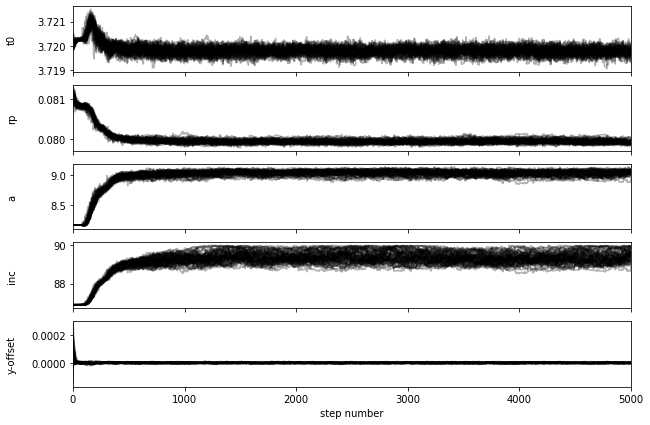

In [24]:
transit_analysis("https://raw.githubusercontent.com/Hamza-Suleman/transiting-exoplanets/main/Transit_model_LC_follow-up_data.txt")

##Running the Function on WASP-121 Data

###Whitelight Dataset - transit_1.136-1.580micr_whitelight.txt


Trying Parameters:
[3.719, 4.78, 0.085, 10, 90.5, 0]


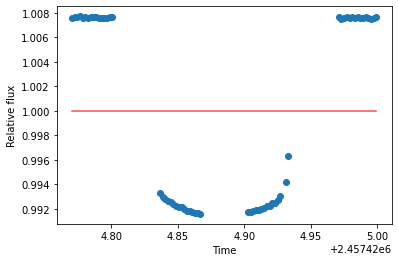


Do these parameters fit?
no
Enter a value for Time of Inferior Conjunction Parameter: 4.885
Enter a value for Orbital Period Parameter: 2.8
Enter a value for Planet Radius Parameter: 0.122
Enter a value for Semi-major Axis Parameter: 9
Enter a value for Orbital Inclination Parameter: 90
Enter a value for Y-Offset Parameter: 0.0075

Trying Parameters:
[4.885, 2.8, 0.122, 9.0, 90.0, 0.0075]


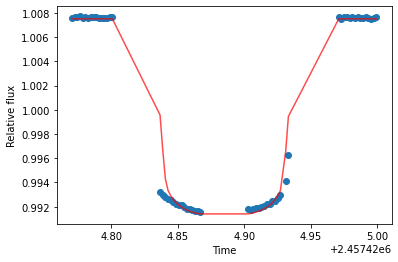


Do these parameters fit?
no
Enter a value for Time of Inferior Conjunction Parameter: 4.885
Enter a value for Orbital Period Parameter: 2.8
Enter a value for Planet Radius Parameter: 0.122
Enter a value for Semi-major Axis Parameter: 8.5
Enter a value for Orbital Inclination Parameter: 90
Enter a value for Y-Offset Parameter: 0.0075

Trying Parameters:
[4.885, 2.8, 0.122, 8.5, 90.0, 0.0075]


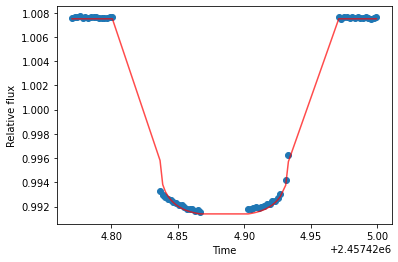


Do these parameters fit?
yes

Final Manual Parameters:
[4.885, 2.8, 0.122, 8.5, 90.0, 0.0075]

Running MCMC Analysis:



  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:15<00:00, 314.81it/s]


These are the variables calculated by MCMC analysis:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Output Parameters from MCMC Analysis


array([[ 1.29772228e+29,  1.29772228e+29,  6.98022219e+41],
       [ 5.05160323e-01,  3.82045554e-01,  3.57320405e-01],
       [ 2.64839444e+30,  2.64839444e+30,  7.44591412e+41],
       [ 4.54718557e+01,  3.24194163e+01,  3.37559587e+01],
       [-5.76197576e-05,  8.40984253e-06,  8.85034015e-06]])

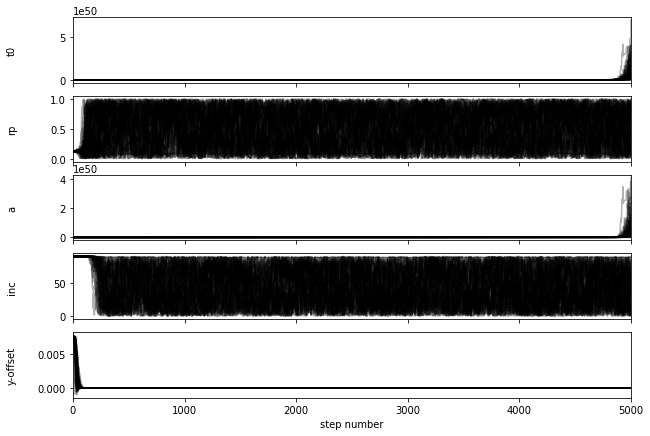

In [32]:
transit_analysis("https://raw.githubusercontent.com/Hamza-Suleman/transiting-exoplanets/main/WASP-121%20Raw%20Data/transit_1.136-1.580micr_whitelight.txt")